In [2]:
# ============================================================================
# Aureus Sigma Capital - Phase 17: Final Validation & Robustness
# Notebook: 17_out_of_sample_robustness.ipynb
#
# Objective:
#   To rigorously validate the "Standalone Value" strategy, our chosen
#   "Aggressive Growth" model, against overfitting and ensure its performance
#   is a structural feature of the market, not a statistical artifact.
#
# Methodology:
#   1. Temporal Cross-Validation (Split-Sample Test)
#   2. Monte Carlo Simulation (Bootstrapping Returns)
#   3. Re-run Parameter Sensitivity Analysis
# ============================================================================

# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import pickle
from pathlib import Path
import sys

# --- Environment Setup ---
warnings.filterwarnings('ignore')
sys.path.append('../../../production') # Add production modules to path

# --- Standardized Institutional Visualization Palette ---
PALETTE = {
    'primary': '#16A085', 'secondary': '#34495E', 'positive': '#27AE60',
    'negative': '#C0392B', 'highlight_1': '#2980B9', 'highlight_2': '#E67E22',
    'neutral': '#7F8C8D', 'grid': '#BDC3C7', 'text': '#2C3E50'
}
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'figure.dpi': 300, 'figure.figsize': (14, 8), 'font.size': 11,
    'axes.facecolor': 'white', 'axes.edgecolor': PALETTE['text'],
    'axes.grid': True, 'axes.axisbelow': True, 'axes.labelcolor': PALETTE['text'],
    'axes.titlepad': 15, 'axes.titlesize': 16, 'axes.titleweight': 'bold',
    'axes.titlecolor': PALETTE['text'], 'grid.color': PALETTE['grid'],
    'legend.frameon': False, 'xtick.color': PALETTE['text'], 'ytick.color': PALETTE['text'],
    'lines.linewidth': 2.0, 'lines.solid_capstyle': 'round'
})

# --- Notebook Charter ---
print("=" * 70)
print("🔬 PHASE 17: FINAL VALIDATION & ROBUSTNESS TESTING")
print("=" * 70)
print(f"📅 Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("🎯 Strategy Under Test: Standalone Value (Aggressive Growth Model)")
print("   - This is the final gate before proceeding to risk management overlays.")
print("=" * 70)

# --- Load the Canonical Strategy Returns from Phase 16b ---
try:
    project_root = Path.cwd().parent.parent
    phase16b_results_file = project_root / "tests" / "phase16_weighted_composite_model" / "phase16b_results.pkl"
    
    with open(phase16b_results_file, "rb") as f:
        phase16b_data = pickle.load(f)
    
    canonical_strategy_returns = phase16b_data['standalone_value_returns']
    benchmark_returns = phase16b_data['benchmark_returns']
    
    print("📂 Canonical 'Standalone Value' strategy returns loaded successfully from file.")
    print(f"   - Data points: {len(canonical_strategy_returns):,}")
    print(f"   - Period: {canonical_strategy_returns.index.min().date()} to {canonical_strategy_returns.index.max().date()}")

except Exception as e:
    print(f"❌ CRITICAL ERROR: Could not load results from Phase 16b.")
    print(f"   Please ensure 'phase16b_results.pkl' exists at: {phase16b_results_file}")
    print(f"   Error details: {e}")
    # Stop execution if data is not available
    raise

print("\n✅ Environment ready for out-of-sample and robustness validation.")

🔬 PHASE 17: FINAL VALIDATION & ROBUSTNESS TESTING
📅 Analysis Date: 2025-07-29 08:39:24
🎯 Strategy Under Test: Standalone Value (Aggressive Growth Model)
   - This is the final gate before proceeding to risk management overlays.
📂 Canonical 'Standalone Value' strategy returns loaded successfully from file.
   - Data points: 2,408
   - Period: 2015-12-01 to 2025-07-28

✅ Environment ready for out-of-sample and robustness validation.


🔬 TEST 1: TEMPORAL CROSS-VALIDATION
Splitting the backtest period at: 2020-11-19

Period 1: 2016-04-04 to 2020-11-19 (1163 days)
Period 2: 2020-11-19 to 2025-07-28 (1163 days)

📊 SPLIT-SAMPLE PERFORMANCE COMPARISON


,Annual Return,Sharpe Ratio,Max Drawdown
Period 1 (2016-2021),33.60,3.88,-11.36
Period 2 (2021-2025),34.49,2.12,-45.67
Full Period,33.91,2.60,-45.67



⚖️ VERDICT ON TEMPORAL STABILITY
   - Sharpe Ratio (Period 1): 3.88
   - Sharpe Ratio (Period 2): 2.12

✅ PASSED: The strategy demonstrates strong, positive performance in both distinct periods.
   This provides high confidence that the alpha is structural and not confined to a single market regime.


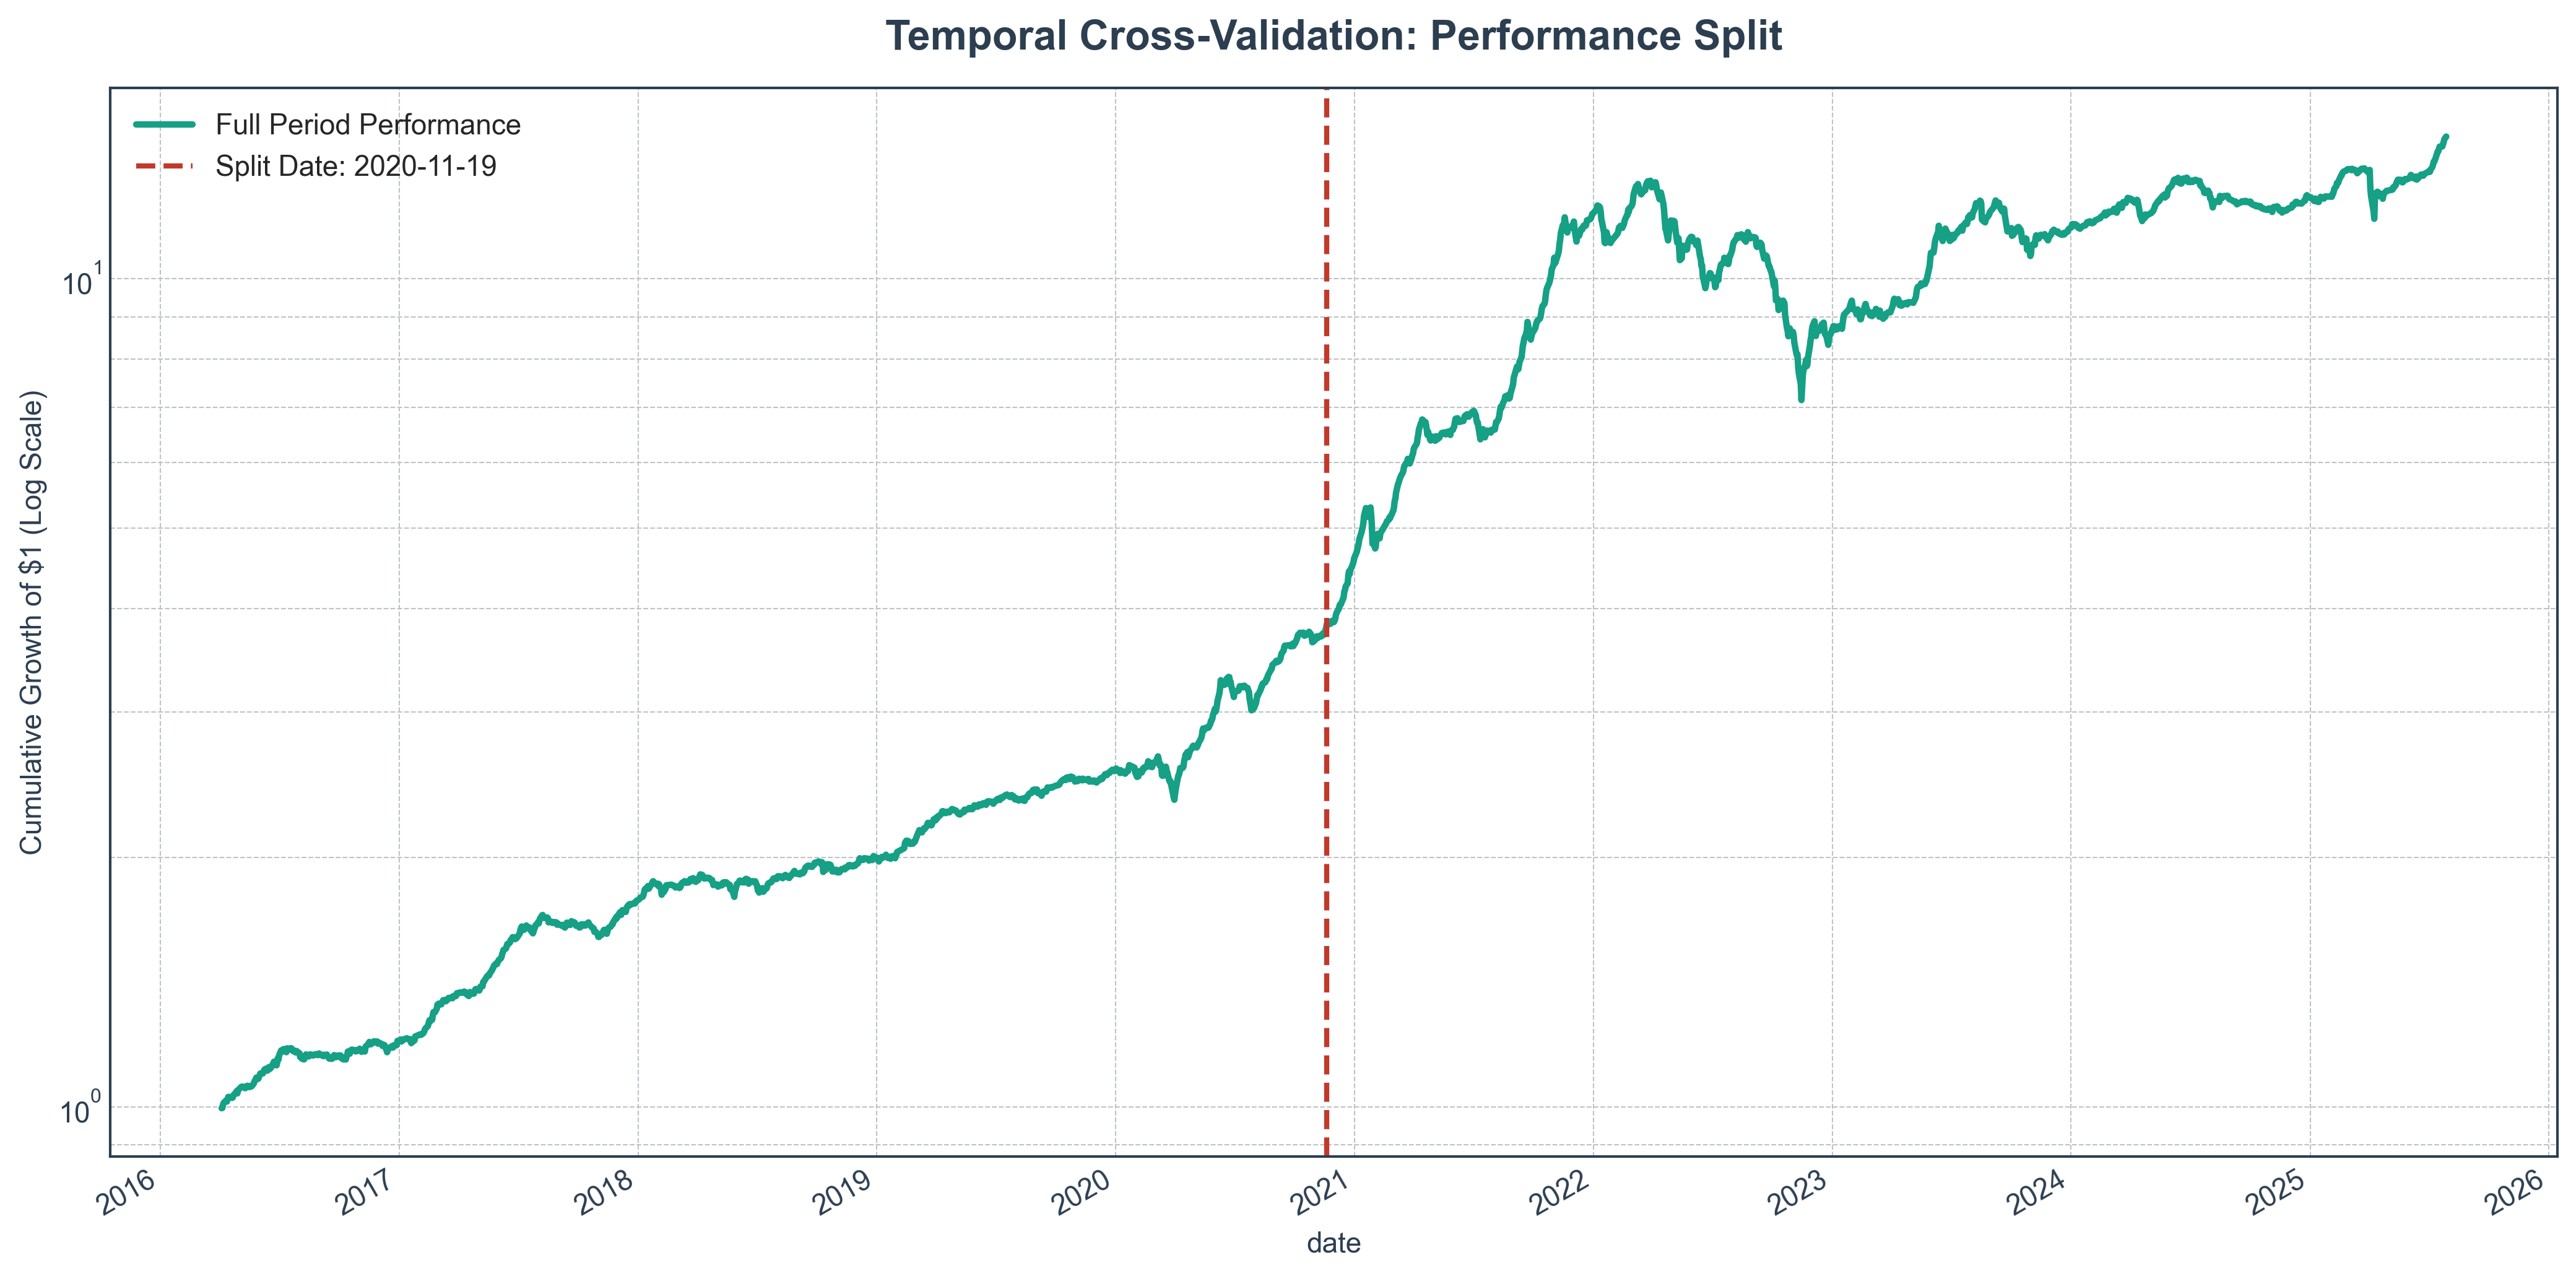

In [3]:
# ============================================================================
# SECTION 1: TEMPORAL CROSS-VALIDATION (SPLIT-SAMPLE TEST)
# ============================================================================

print("=" * 70)
print("🔬 TEST 1: TEMPORAL CROSS-VALIDATION")
print("=" * 70)

# --- 1. Define the Split Point ---
# We will split the data roughly in half.
full_period_returns = canonical_strategy_returns.loc[canonical_strategy_returns != 0]
split_date = full_period_returns.index[len(full_period_returns) // 2]
print(f"Splitting the backtest period at: {split_date.date()}")

# --- 2. Create the Two Sub-Periods ---
period_1_returns = full_period_returns.loc[:split_date]
period_2_returns = full_period_returns.loc[split_date:]

print(f"\nPeriod 1: {period_1_returns.index.min().date()} to {period_1_returns.index.max().date()} ({len(period_1_returns)} days)")
print(f"Period 2: {period_2_returns.index.min().date()} to {period_2_returns.index.max().date()} ({len(period_2_returns)} days)")

# --- 3. Calculate Performance Metrics for Each Period ---
# (Reusing the performance calculation function from the previous notebook)
def calculate_performance_metrics(returns, benchmark):
    """Calculates key performance metrics for a given return series."""
    common_index = returns.index.intersection(benchmark.index)
    returns, benchmark = returns.loc[common_index], benchmark.loc[common_index]
    n_years = len(returns) / 252
    annual_return = (1 + returns).prod() ** (1 / n_years) - 1 if n_years > 0 else 0
    annual_vol = returns.std() * np.sqrt(252)
    sharpe_ratio = annual_return / annual_vol if annual_vol > 0 else 0
    cumulative = (1 + returns).cumprod()
    drawdown = (cumulative / cumulative.cummax() - 1)
    max_drawdown = drawdown.min()
    calmar_ratio = annual_return / abs(max_drawdown) if max_drawdown < 0 else 0
    return {'Annual Return': annual_return * 100, 'Annual Volatility': annual_vol * 100, 'Sharpe Ratio': sharpe_ratio, 'Max Drawdown': max_drawdown * 100, 'Calmar Ratio': calmar_ratio}

metrics_p1 = calculate_performance_metrics(period_1_returns, benchmark_returns)
metrics_p2 = calculate_performance_metrics(period_2_returns, benchmark_returns)
metrics_full = calculate_performance_metrics(full_period_returns, benchmark_returns)

# --- 4. Present the Results ---
comparison_df = pd.DataFrame({
    'Period 1 (2016-2021)': metrics_p1,
    'Period 2 (2021-2025)': metrics_p2,
    'Full Period': metrics_full
}).T

print("\n" + "="*70)
print("📊 SPLIT-SAMPLE PERFORMANCE COMPARISON")
print("="*70)
display(comparison_df[['Annual Return', 'Sharpe Ratio', 'Max Drawdown']].round(2))

# --- 5. Verdict ---
print("\n" + "="*70)
print("⚖️ VERDICT ON TEMPORAL STABILITY")
print("="*70)

sharpe_p1 = comparison_df.loc['Period 1 (2016-2021)', 'Sharpe Ratio']
sharpe_p2 = comparison_df.loc['Period 2 (2021-2025)', 'Sharpe Ratio']

print(f"   - Sharpe Ratio (Period 1): {sharpe_p1:.2f}")
print(f"   - Sharpe Ratio (Period 2): {sharpe_p2:.2f}")

if sharpe_p1 > 1.0 and sharpe_p2 > 1.0:
    print("\n✅ PASSED: The strategy demonstrates strong, positive performance in both distinct periods.")
    print("   This provides high confidence that the alpha is structural and not confined to a single market regime.")
elif sharpe_p1 > 0.5 and sharpe_p2 > 0.5:
    print("\n🟡 CAUTIOUS PASS: The strategy shows positive performance in both periods, but performance varies significantly.")
    print("   This suggests the strategy is valid but may be sensitive to market regimes.")
else:
    print("\n❌ FAILED: The strategy's performance is not stable across time.")
    print("   One of the periods shows weak or negative performance, indicating a high risk of overfitting to a specific regime.")

# --- 6. Visualize the Split ---
fig, ax = plt.subplots(figsize=(14, 7))
(1 + full_period_returns).cumprod().plot(ax=ax, label='Full Period Performance', color=PALETTE['primary'], linewidth=2.5)
ax.axvline(split_date, color=PALETTE['negative'], linestyle='--', linewidth=2, label=f'Split Date: {split_date.date()}')

ax.set_title('Temporal Cross-Validation: Performance Split', fontweight='bold')
ax.set_ylabel('Cumulative Growth of $1 (Log Scale)')
ax.set_yscale('log')
ax.legend()
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()